In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [20]:
import numpy as np
import pandas as pd


from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [5]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2122/dataset/"

def get_file(filename):
    IS_COLAB = ('google.colab' in str(get_ipython()))
    if IS_COLAB:
        urllib.request.urlretrieve (url+filename, filename)
        return filename
    else:
        return filepath+filename

In [6]:
# Parameters
n_classes = 4
n_estimators = 16
plot_colors = colors[0:4]
markers = ('D','s','^','o')

In [7]:
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

In [8]:
# Load fruit data
fruit_file = open(get_file('Random_Forest_Examples.csv'),'r')
next(fruit_file)
fruit = []

for line in fruit_file:
    fruit.append(line.strip().split(','))

In [9]:
dff = pd.read_csv(get_file('Random_Forest_Examples.csv'))
fruit = np.array(dff)

In [10]:
rows = len(fruit)
columns = len(fruit[0])
    
fruit = np.array(fruit)

enc = OrdinalEncoder()
enc = enc.fit(fruit)

fruit = enc.transform(fruit)
labels = enc.categories_[0]

In [25]:
for column in range(0,columns ):
    # loop through all the rows and columns, replace
    # categories with floats
    cnt1 = 0
    categories = {}
    for row in range(0,rows):
        if (row == 0): 
           try:
               num = float( fruit[row,column] )
               # if this is a number, break from the loop
               break
           except:
               pass
        
        item = fruit[row,column]
        if (item not in categories):
            # see if we already have an item of this category
            #  basically, change apples to 1, bananas to 2, oranges to 3
            #  etc
            categories[item] = cnt1
            cnt1+=1
        fruit[row,column] = categories[item]

    if (column == 0):
        labels = {}
        for key, value in categories.items():
            # labels for the legend in the plots
            labels[int(value)] = key


fruit = fruit.astype(np.float)
#fruit

KeyError: 0

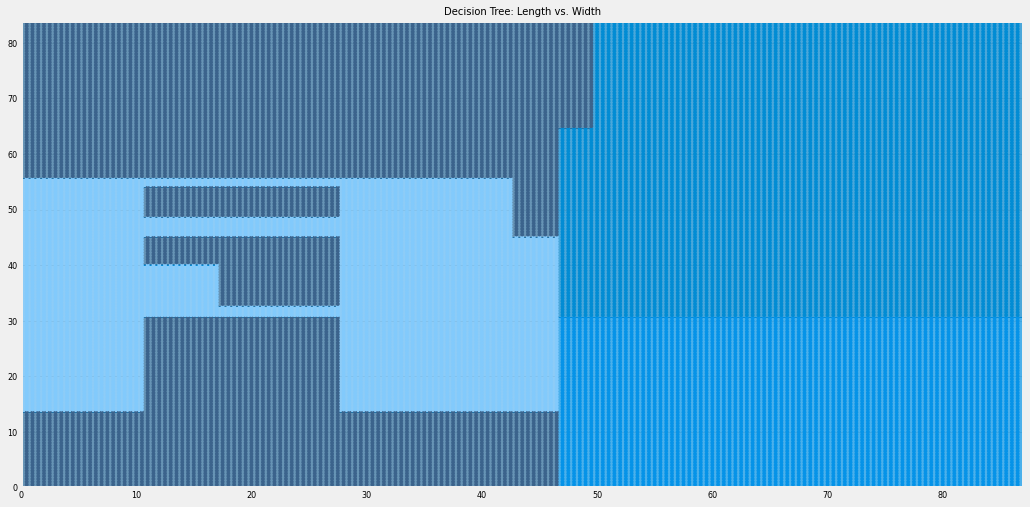

In [26]:
plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)  ]
          
titles = ["Decision Tree: Length vs. Width",
          "Random Forest: Length vs. Width",
          "Decision Tree: Length vs. Color",
          "Random Forest: Length vs. Color"]
cnt1 = 0
y_labels = ['Width (inch)','Width (inch)',
          'Color (as a number 0-3)','Color (as a number 0-3)']

for pair in ([1,2], [1,3]):
    for model in models:
        # We only take the two corresponding features
        X = fruit[:,pair].astype(np.float)
        y = fruit[:,0]
        
        np.random.seed(RANDOM_SEED)

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        
        model_title = titles[cnt1]
        plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = 0, X[:, 0].max() + 1
        y_min, y_max = 0, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=.7)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use 
            estimator_alpha = 0.8 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser), np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, cmap=cmap, s=60, marker=markers[i], label=labels[i])
            plt.legend(loc=1)
            plt.xlabel('Length (inch)')
            plt.ylabel(y_labels[cnt1])


        plt.show()
        cnt1+=1